# Lab 2: Naturalistic narrative processing

In this notebook, we'll isolate stimulus-driven neural responses to a natural spoken narrative using intersubject correlation (ISC) analysis. We'll analyze fMRI responses to both an intact and a scrambled version of the story stimulus to identify areas that track higher-level, slower-evolving narrative features only present in the intact story.

In [1]:
from os.path import exists
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

For the following exercises, we'll use an open fMRI data developed by Chien & Honey ([2020](https://doi.org/10.1016/j.neuron.2020.02.013)) and provided as part of the [Narratives](https://snastase.github.io/datasets/ds002345) dataset ([Nastase et al., 2021](https://doi.org/10.1038/s41597-021-01033-3)). In this dataset, subjects listen to two different versions of a \~9-minute natural spoken narrative called "[It's Not the Fall that Gets You](https://themoth.org/stories/its-not-the-fall-that-gets-you)" by Andy Christie and recorded by [The Moth](https://themoth.org/). This is a fairly large dataset (\~3 GB) and may take awhile to download (e.g., 30 minutes); we want responses to the full stimulus for a $N = 20$ subjects for ISC analysis. To download the data, you can use `curl` on Mac, `wget` on Linux, or just download manually from Zenodo: https://zenodo.org/records/4300904. Extract the dataset from the archive (e.g., using `tar`) and make sure it's located in a reasonable place (e.g., in the same directory as this notebook). Try to avoid inadvertently running this cell multiple times!

In [2]:
# Check if data directory already exists
if not exists('brainiak-aperture-isc-data'):

    # Download and extract example data from Zenodo
    # For Mac, use curl; for Linux use wget
    #!wget https://zenodo.org/records/4300904/files/brainiak-aperture-isc-data.tgz
    !curl -O https://zenodo.org/records/4300904/files/brainiak-aperture-isc-data.tgz
    
    # Extract from data from archive
    !tar -xzf brainiak-aperture-isc-data.tgz
    
    # Consider removing the big archive when you have the data
    #!rm brainiak-aperture-isc-data.tgz

else:
    print("Looks like the dataset was already downloaded!")

Looks like the dataset was already downloaded!


First we'll compile the file names corresponding to the fMRI scans collected while participants listened to the "intact" (`task-notthefallintact`) version of the stimulus. There are $400~\mathrm{TRs}$ (time points) in this dataset and $\mathrm{TR} = 1.5~\mathrm{s}$. These data have already been subjected to preprocessing, standardization to MNI space, and confound regression to minimize nuisance variables like head motion.

In [3]:
# Get filenames of data for intact stimulus
# Adjust the path depending on where you downloaded the dataset
intact_fns = sorted(glob('brainiak-aperture-isc-data/sub-*_task-notthefallintact_*bold.nii.gz'))

# Establish some metadata for this dataset
n_trs = 400
tr = 1.5

Many published studies compute ISC values for every voxel (yielding, e.g., ~50,000 ISC values). To reduce some computational demand, we'll first average voxel-level time series into a larger parcels based on a widely-used atlas derived from functional connectivity ([Schaefer et al., 2018](https://doi.org/10.1093/cercor/bhx179); conveniently provided by Nilearn's `fetch_atlas_schaefer_2018`). This atlas comes in several levels of spatial granularity; we'll use the version with 200 parcels tiling the cortex. In each subject, this will yield a time series of BOLD activity (400 TRs long) at each of 200 parcels.

In [4]:
# First we'll load in the Schaefer atlas from nilearn
from nilearn.datasets import fetch_atlas_schaefer_2018

# Adjust this path to match where your nilearn-data live
nilearn_dir = '/Users/snastase/Work/psyc599/nilearn-data'

n_parcels = 200
atlas_schaefer = fetch_atlas_schaefer_2018(n_rois=200, data_dir=nilearn_dir)

[fetch_atlas_schaefer_2018] Dataset found in /Users/snastase/Work/psyc599/nilearn-data/schaefer_2018


Take a moment to plot this atlas using `plot_roi` from `nilearn.plotting`. You can set `cmap=atlas_schaefer.lut` for nicer colors (see the [documentation](https://nilearn.github.io/dev/auto_examples/01_plotting/plot_atlas.html) for hints).

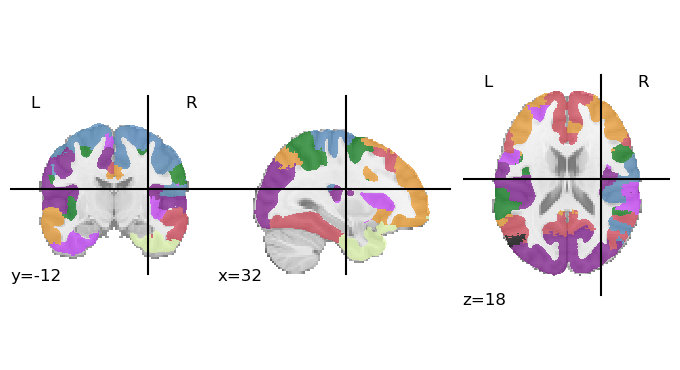

In [5]:
# Plot Schaefer atlast using plot_roi:
from nilearn.plotting import plot_roi

plot_roi(atlas_schaefer.maps, cmap=atlas_schaefer.lut,
         colorbar=False);

Now, we'll use `MultiNiftiLabelsMasker` from `nilearn.maskers` to extract the average time series at each parcel. Remember, you'll need to first initialize the masker, then use `.fit_transform()` to apply it to your actual data. (Try initializing the masker with `standardize=None` to avoid all the warnings—these data were already z-scored.) This cell may take a couple minutes to run.

In [6]:
# Use MultiNiftiLabelsMasker to extract mean time series per parcel:
from nilearn.maskers import MultiNiftiLabelsMasker

atlas_masker = MultiNiftiLabelsMasker(atlas_schaefer.maps, standardize=None)
intact_parcels = atlas_masker.fit_transform(intact_fns)

Check the shape of a dataset in the output list to ensure you undestand which dimensions correspond to what.

In [7]:
# Check representative dataset shape:
intact_parcels[0].shape

(400, 200)

Intersubject correlation (ISC) analysis ([Hasson et al., 2004](https://doi.org/10.1126/science.1089506); [Nastase et al., 2019](https://doi.org/10.1093/scan/nsz037)) identifies brain regions where activity is synchronized across subjects. Why is neural activity synchronized across subjects? —because they viewed the same stimulus. In other words, ISC analysis isolates stimulus-driven processing. Note, however, that *any* features of the stimulus can drive neural synchrony across different brain areas; ISC in lower-order perceptual areas may be driven by low-level sensory features whereas ISC in higher-order association areas may be driven by higher-level stimulus features. This data-driven approach is content-agnostic: alone, it can tell us "where" and "how much" neural activity is driven by the stimulus, but not "what" stimulus features are driving neural activity.

To compute the correlations more efficiently (instead of, e.g., looping across parcels), we'll use this custom `array_correlation` function. This function will effectively compute the column-wise Pearson correlations between two 2-dimensional arrays across all columns (i.e., parcels) simultaneously. Make sure you understand what each line of the function is doing.

In [8]:
# Array correlation function to avoid loops
def array_correlation(x, y, axis=0):
    
    # Center (de-mean) input variables
    x_demean = x - np.mean(x, axis=axis)
    y_demean = y - np.mean(y, axis=axis)

    # Compute summed product of centered variables
    numerator = np.sum(x_demean * y_demean, axis=axis)

    # Compute sum squared error
    denominator = np.sqrt(np.sum(x_demean ** 2, axis=axis) *
                          np.sum(y_demean ** 2, axis=axis))

    return numerator / denominator

*Bonus:* Create two random vectors and use `np.isclose` to check that my `array_correlation` function yields comparable values to `np.corrcoef` and `pearsonr` from `scipy.stats`:

In [9]:
# Bonus: check correlation functions:
from scipy.stats import pearsonr

np.random.seed(1312)
a, b = np.random.randn(30), np.random.randn(30)
corrcoef_r = np.corrcoef(a, b)[0, 1]
pearsonr_r = pearsonr(a, b)[0]
array_r = array_correlation(a, b)
print(f"corrcoef = {corrcoef_r}")
print(f"pearsonr = {pearsonr_r}")
print(f"array_correlation = {array_r}")
assert np.isclose(array_r, corrcoef_r) & np.isclose(array_r, pearsonr_r)

corrcoef = -0.09378200630773796
pearsonr = -0.09378200630773803
array_correlation = -0.09378200630773803


Next, I'll give you a simple function that uses the `array_correlation` function to compute ISC values for a list a subject datasets. There are two ways to compute ISC values: (1) computing the ISC between each pair of subjects; or (2) computing the ISC between each subject and the mean time series of the other subjects. For this exercise, we'll use the latter leave-one-subject-out approach. The following function computes parcel-wise ISCs given a list $TRs~\times parcels$ arrays where each array corresponds to one $N$ subjects. Add comments where indicated to describe what each chunk of code is doing.

In [10]:
# Comment on this ISC function
def isc(data, axis=0):

    # [YOUR COMMENT]
    n_subjects = len(data)
    subject_ids = np.arange(n_subjects)
    data_stack = np.stack(data, axis=0)

    # [YOUR COMMENT]
    isc_results = []
    for loo_id in subject_ids:

        # [YOUR COMMENT]
        loo_others = [s for s in subject_ids if s != loo_id]

        # [YOUR COMMENT]
        loo_mean = np.mean(data_stack[loo_others], axis=0)

        # [YOUR COMMENT]
        loo_subject = data_stack[loo_id]

        # [YOUR COMMENT]
        isc_result = array_correlation(loo_subject, loo_mean, axis=axis)
        
        isc_results.append(isc_result)
    
    isc_results = np.stack(isc_results, axis=0)

    return isc_results

Run this ISC function on the list of subject-level datasets and check the shape of the outputs ISC results.

In [11]:
# Run the ISC function on the parcel data:
intact_iscs = isc(intact_parcels)

# Check the shape of the ISC outputs:
print(intact_iscs.shape)

(20, 200)


For this exercise, we'll ignore statistical testing and simply average the ISC values across subjects. Compute the mean parcel-wise ISC values. Next, use the masker's `inverse_transform()` method to project the parcel-level data back into a voxel-resolution ISC map. Check the shape of the ISC image to ensure it makes sense.

In [12]:
# Average ISC values across subjects:
intact_mean = np.mean(intact_iscs, axis=0)

# Inverse-transform parcel ISCs back to voxels:
intact_img = atlas_masker.inverse_transform(intact_mean)

# Check shape of ISC map:
print(intact_img.shape)

(65, 77, 49)


Now, let's plot the the mean ISC value. We'll plot these ISC values in two ways. First, plot the ISC values using `plot_glass_brain` with `display_mode='lzr'`, `plot_abs=False`, and a `threshold` of $r = .2$.

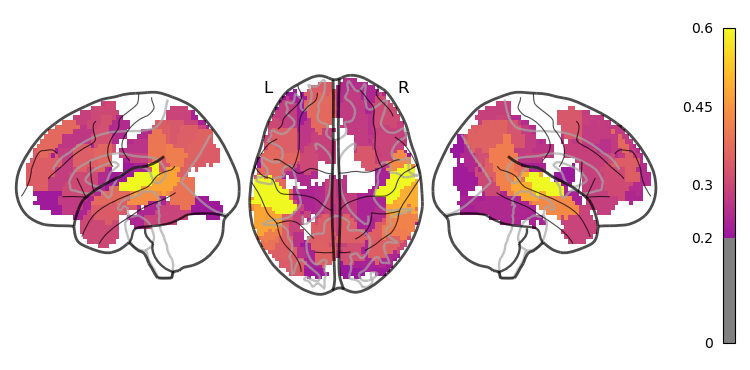

In [13]:
# Plot average ISC map on glass brain:
from nilearn.plotting import plot_glass_brain

threshold = .2
plot_glass_brain(intact_img, display_mode='lzr',
                 threshold=threshold, plot_abs=False,
                 cmap='plasma', vmin=.0, vmax=.6);

Look how strong those correlation values are! We can think of the ISC value as an intersubject formulation of a "noise ceiling"; that is, an estimate of how much reliable signal we have in the dataset. ISC doesn't tell us what stimulus features are encoded in the fMRI activity—we would need an explicit model for that (see the subsequent lab on "encoding models"). However, it can give us an estimate of the "ceiling": how much variance is available for us to model.

Next, let's look at some specific slices. Plot the data twice using `plot_stat_map`. In the first plot, set `cut_coords = (-57, -24, 9)`—this will give a good view of earlier auditory cortex and neighboring language areas. In the second plot, set `cut_coords = (-3, -65, 40)` to get a view of the precuneus (in the default-mode network). Use the same threshold as the previous plot.

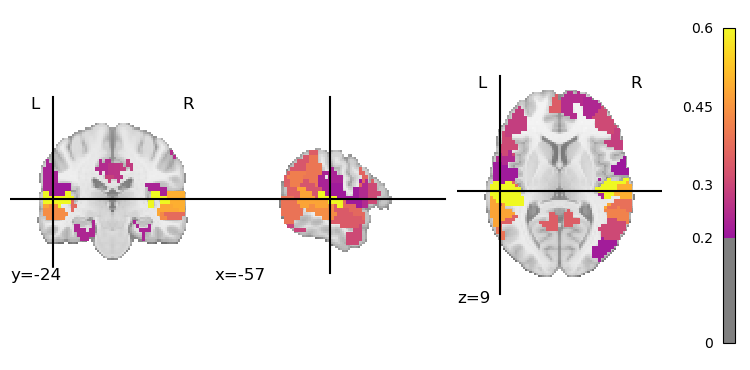

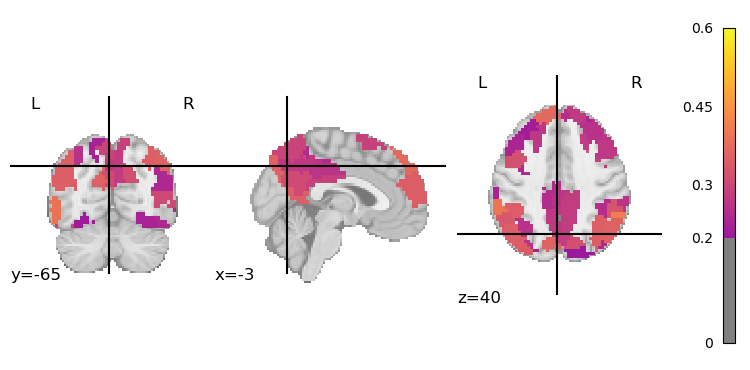

In [14]:
# Plot average ISC stat map (-57, -24, 9):
from nilearn.plotting import plot_stat_map

threshold = .2
cut_coords = (-57, -24, 9)
plot_stat_map(intact_img, cut_coords=cut_coords,
              threshold=threshold,
              cmap='plasma', vmin=.0, vmax=.6);

# Plot average ISC stat map (-3, -62, 40):
cut_coords = (-3, -65, 40)
plot_stat_map(intact_img, cut_coords=cut_coords,
              threshold=threshold,
              cmap='plasma', vmin=.0, vmax=.6);

The previous analysis shows us areas of the brain driven by features of the intact story stimulus, including both low-level (quickly fluctuating) sensory features and higher-level (slowly fluctuating) linguistic/narrative features. To identify brain areas associated with higher-level narrative features, Lerner and colleagues ([2011](https://doi.org/10.1523/JNEUROSCI.3684-10.2011)) manipulated their stimulus to disrupt higher-level narrative features: they scrambled the story stimulus at the word, sentence, and paragraph levels. The present dataset from Chien and Honey ([2020]()) includes fMRI activity recorded while a group of participants listened to a scrambled version of the story (`task-notthefallshortscram`) where only short sequences of words were intact and these segments were otherwise randomized. This stimulus manipulation retains the low level sensory features of the stimulus, including the meaning of individual words—but removes any meaningful links across phrases/sentences as well as the higher-level narrative structure.

In the following cell, re-run the key lines of code from above to reproduce the same analysis on the fMRI files corresponding to the scrambled condition. This means specifying the filenames, re-applying the atlas masker, computing the ISCs, averaging the ISC values across subjects, and inverting the masker to construct an ISC map for the scrambled condition.

In [15]:
# Get filenames of data for intact stimulus
scram_fns = sorted(glob('brainiak-aperture-isc-data/sub-*_task-notthefallshortscram_*bold.nii.gz'))

# Use masker to extract mean time series per parcel:
scram_parcels = atlas_masker.fit_transform(scram_fns)

# Run the ISC function on the parcel data:
scram_iscs = isc(scram_parcels)

# Average ISC values across subjects:
scram_mean = np.mean(scram_iscs, axis=0)

# Inverse-transform parcel ISCs back to voxels:
scram_img = atlas_masker.inverse_transform(scram_mean)

Plot the scrambled ISC map using the same `plot_glass_brain` code from above.

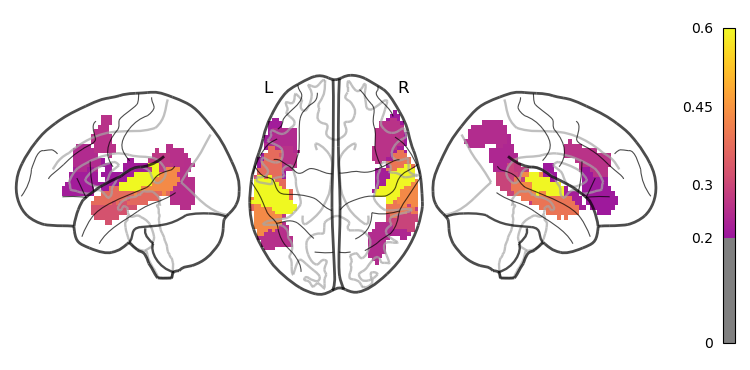

In [16]:
# Plot average ISC map on glass brain:
threshold = .2
plot_glass_brain(scram_img, display_mode='lzr',
                 threshold=threshold, plot_abs=False,
                 cmap='plasma', vmin=.0, vmax=.6);

Finally, use `plot_stat_map` to plot the scrambled ISCs for the same slices from above.

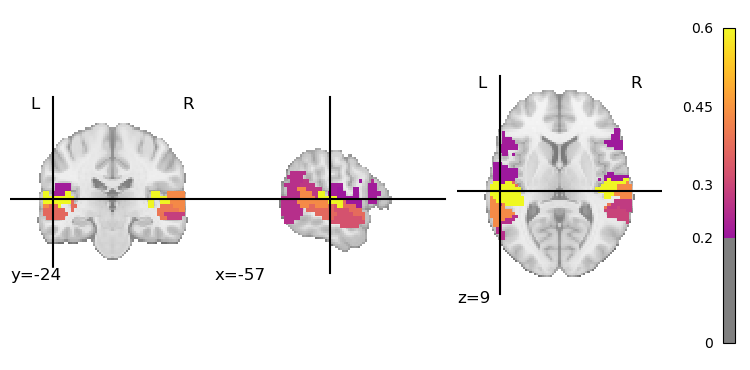

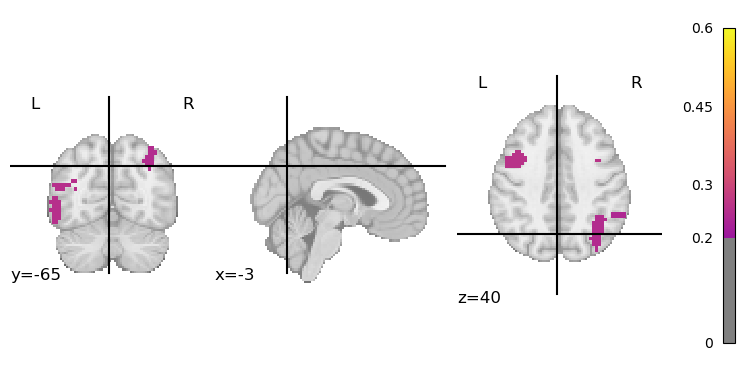

In [17]:
# Plot average ISC stat map (-57, -24, 9):
threshold = .2
cut_coords = (-57, -24, 9)
plot_stat_map(scram_img, cut_coords=cut_coords,
                 threshold=threshold,
                 cmap='plasma', vmin=.0, vmax=.6);

# Plot average ISC stat map (-3, -65, 40):
threshold = .2
cut_coords = (-3, -65, 40)
plot_stat_map(scram_img, cut_coords=cut_coords,
                 threshold=threshold,
                 cmap='plasma', vmin=.0, vmax=.6);

Write a brief reflection (a couple sentences) about what you learned from these analyses. Consider the following points in your response:

* How does the intact ISC map compare to the language areas you identified in Lab 1? How does it compare to the "core language network" popularized by [Fedorenko et al., 2024](https://doi.org/10.1038/s41583-024-00802-4)?

* Interpret the differences between the ISC maps for the intact and scrambled conditions.

* How might you begin to more explicitly model the stimulus features driving the ISCs you observe?

#### Reflection
*Your response here!*

### References
* Chien, H. Y. S., & Honey, C. J. (2020). Constructing and forgetting temporal context in the human cerebral cortex. *Neuron*, *106*(4), 675–686. https://doi.org/10.1016/j.neuron.2020.02.013

* Fedorenko, E., Ivanova, A. A., & Regev, T. I. (2024). The language network as a natural kind within the broader landscape of the human brain. *Nature Reviews Neuroscience*, *25*(5), 289–312. https://doi.org/10.1038/s41583-024-00802-4

* Hasson, U., Nir, Y., Levy, I., Fuhrmann, G., & Malach, R. (2004). Intersubject synchronization of cortical activity during natural vision. *Science*, *303*(5664), 1634–1640. https://doi.org/10.1126/science.1089506

* Lerner, Y., Honey, C. J., Silbert, L. J., & Hasson, U. (2011). Topographic mapping of a hierarchy of temporal receptive windows using a narrated story. *Journal of Neuroscience*, *31*(8), 2906–2915. https://doi.org/10.1523/JNEUROSCI.3684-10.2011

* Nastase, S. A., Gazzola, V., Hasson, U., & Keysers, C. (2019). Measuring shared responses across subjects using intersubject correlation. *Social Cognitive and Affective Neuroscience*, *14*(6), 667–685. https://doi.org/10.1093/scan/nsz037

* Nastase, S. A., Liu, Y.-F., Hillman, H., Zadbood, A., Hasenfratz, L., Keshavarzian, N., Chen, J., Honey, C. J., Yeshurun, Y., Regev, M., Nguyen, M., Chang, C. H. C., Baldassano, C., Lositsky, O., Simony, E., Chow, M. A., Leong, Y. C., Brooks, P. P., Micciche, E., Choe, G., Goldstein, A., Vanderwal, T., Halchenko, Y. O., Norman, K. A., & Hasson, U. (2021). The “Narratives” fMRI dataset for evaluating models of naturalistic language comprehension. *Scientific Data*, *8*, 250. https://doi.org/10.1038/s41597-021-01033-3

* Schaefer, A., Kong, R., Gordon, E. M., Laumann, T. O., Zuo, X. N., Holmes, A. J., Eickhoff, S. B., & Yeo, B. T. (2018). Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. *Cerebral Cortex*, *28*(9), 3095–3114. https://doi.org/10.1093/cercor/bhx179